## Definição de Funções

### Função responsável por fazer a leitura das imagens.

Parâmetros:
    directory é o diretório contendo as contendo as pastas de cada classe com as respectivas imagens
    input_shape (img_width, img_height, n_chanel)
    
Retornar 2 numpyArrays: 
    1º numpyArray contendo as informações das imagens
    2º numpyArray contendo as classes

In [1]:
def read_images_from_directory(directory, input_shape) :
    import glob
    import numpy as np 
    from PIL import Image
    from scipy import misc
    import cv2
    

    ## Leitura da base de dados
    classes = glob.glob (directory + "/*" ) ## Array contendo o diretorio de cada classe
    #print(classes)
    X = []
    y = []
    labels = []
    for i in range(len(classes)): # Para cada diretorio, lê todas as imagens
        files = glob.glob (classes[i] + "/*") 
        for myFile in files: 
            im = Image.open(myFile)
        
            image_resized = im.resize((input_shape[0], input_shape[1]), Image.NEAREST)      # use nearest neighbour
            #image_resized = im.resize((input_shape[0], input_shape[1]), Image.BILINEAR)     # linear interpolation in a 2x2 environment
            #image_resized = im.resize((input_shape[0], input_shape[1]), Image.BICUBIC)      # cubic spline interpolation in a 4x4 environment
            #image_resized = im.resize((input_shape[0], input_shape[1]), Image.ANTIALIAS)    # best down-sizing filter

            image_resized = np.array(image_resized)

            X.append (image_resized)
            y.append (classes[i] .split('/')[-1])  ## Array contendo o labels das classes
            labels.append(myFile.split('/')[-1].split('.')[0])
            
    del directory, classes, i, files, myFile, image_resized # Remove as variaveis que nao serao mais utilizadas
    
    return np.asarray(X), np.asarray(y), np.asarray(labels)

### Função responsável por criar e retornar os geradores de imagens que serão utilizados

Parâmetros:
    X_train são os dados das imagens de treinamento
    y_train são os labels das imagens de treinamento
    X_test são os dados das imagens de test
    y_test são os labels das imagens de test
    
Retornar 2 ImageDataGenerator: 
    1º ImageDataGenerator para as imagens de treinamento
    2º ImageDataGenerator para as imagens de test

In [2]:
def create_ImageDataGenerators(X_train, y_train, X_test, y_test):
    from keras.preprocessing.image import ImageDataGenerator
    
    gerador_treinamento = ImageDataGenerator(rotation_range = 7,
                                         horizontal_flip = True,
                                         shear_range = 0.2,
                                         height_shift_range = 0.07,
                                         zoom_range = 0.2)
    gerador_teste = ImageDataGenerator()
    
    base_treinamento = gerador_treinamento.flow(X_train,
                                                y_train, batch_size = batch_size 
                                                #, save_to_dir = 'dataset_personagens/augment'
                                               )
    
    base_teste = gerador_teste.flow(X_test, y_test, batch_size = batch_size)
    
    return base_treinamento, base_teste

### Função responsável pelo plot dos resultados

In [3]:
def plot_graphs(cnn):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure().set_size_inches(20, 8)
    
    # Accuracy vs Validation Accuracy
    plt.subplot(1, 2, 1)
    #plt.figure(0)
    plt.plot(cnn.history['acc'],'r')
    plt.plot(cnn.history['val_acc'],'g')
    plt.xticks(np.arange(0, epochs, 10))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy / Loss")
    plt.title("Accuracy vs Loss")
    plt.legend(['acc','val_acc'])
    plt.ylim(0, 1.01)
    #plt.show()

    # Loss vs Validation Loss
    plt.subplot(1, 2, 2)
    #plt.figure(1)
    plt.plot(cnn.history['loss'],'b', linestyle = '--')
    plt.plot(cnn.history['val_loss'],'y', linestyle = '--')
    plt.xticks(np.arange(0, epochs, 10))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])
    plt.show()

### Parâmetros do algoritmo

In [4]:
# dimensions of our images.
img_width = 64
img_height = 64
img_chanels = 3

train_data_dir = 'dataset_personagens/training_set'
validation_data_dir = 'dataset_personagens/test_set'

nb_train_samples = 196
nb_validation_samples = 73

epochs = 100
batch_size = 32

K = 5 # número de folds do cross validation

input_shape = (img_width, img_height, img_chanels)   # (img_width, img_height, n_chanel)

## Algoritmo

In [5]:
import numpy as np

### Leitura dos dados

In [6]:
X_treinamento, y_treinamento, _ = read_images_from_directory(train_data_dir, input_shape)

In [7]:
print('Dados imagens treinamento:' ,X_treinamento.shape) # (qtde registros, img_width, img_height, n_chanel)
print('Classe imagens treinamento:' ,y_treinamento.shape) # (qtde registros,)

Dados imagens treinamento: (196, 64, 64, 3)
Classe imagens treinamento: (196,)


Deixa os valores dos pixels no intervalo [0,1]

In [8]:
X_treinamento = X_treinamento.astype('float32')
X_treinamento /= 255

Converte as classes de string para inteiros

In [9]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_treinamento = labelencoder.fit_transform(y_treinamento)

print(labelencoder.classes_)

['training_set\\bart' 'training_set\\homer']


Divide os dados em K folds de forma a manter o balanceamento do conjunto de dados originais

In [10]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = K)
skf.get_n_splits(X_treinamento, y_treinamento)

5

# Treinamento do modelo de Machine Learning

## Definição do modelo

In [11]:
def create_network():
    from keras.models import Sequential
    from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

    classificador = Sequential()
    classificador.add(Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu'))
    classificador.add(MaxPooling2D(pool_size = (2, 2)))
    
    classificador.add(Conv2D(32, (3, 3), activation = 'relu'))
    classificador.add(MaxPooling2D(pool_size = (2, 2)))
    
    classificador.add(Flatten())
    
    classificador.add(Dense(units = 4, activation = 'relu'))
    classificador.add(Dense(units = 4, activation = 'relu'))
    classificador.add(Dense(units = 1, activation = 'sigmoid'))
    
    return classificador

Agora o algoritmo será executado K vezes realizando o cross validation

FOLD:  1 / 5 TRAIN sets: 156 TEST  sets: 40


Using TensorFlow backend.


Accuracy:  0.75
Matriz de confusão:
[[23  1]
 [ 9  7]]


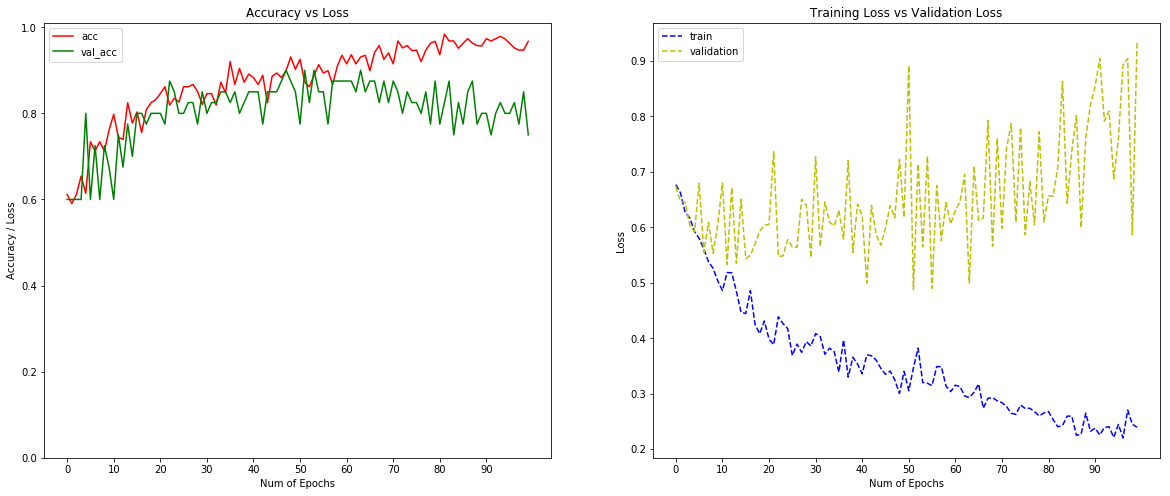

FOLD:  2 / 5 TRAIN sets: 156 TEST  sets: 40
Accuracy:  0.95
Matriz de confusão:
[[22  2]
 [ 0 16]]


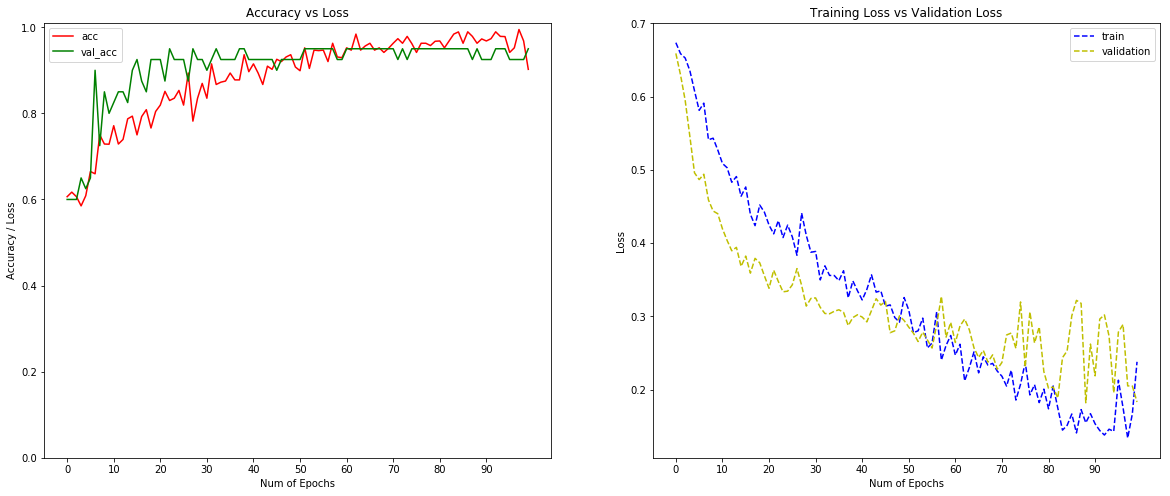

FOLD:  3 / 5 TRAIN sets: 156 TEST  sets: 40
Accuracy:  0.725
Matriz de confusão:
[[19  5]
 [ 6 10]]


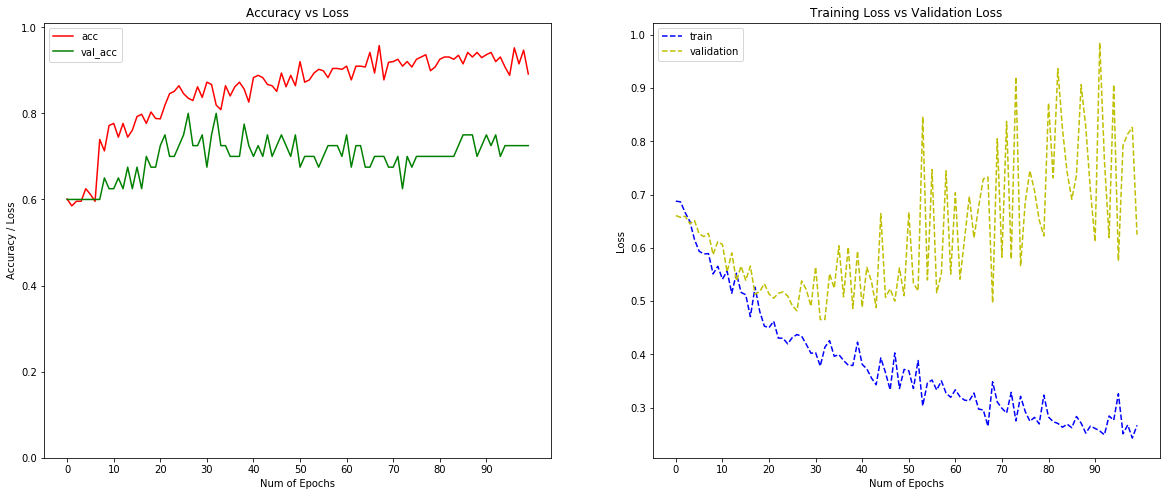

FOLD:  4 / 5 TRAIN sets: 158 TEST  sets: 38
Accuracy:  0.7105263157894737
Matriz de confusão:
[[21  2]
 [ 9  6]]


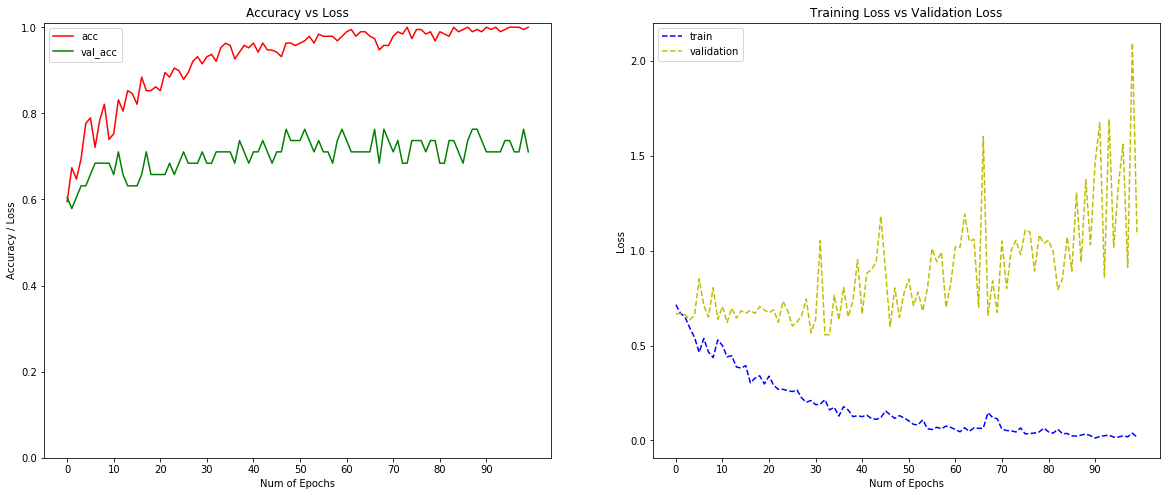

FOLD:  5 / 5 TRAIN sets: 158 TEST  sets: 38
Accuracy:  0.868421052631579
Matriz de confusão:
[[21  2]
 [ 3 12]]


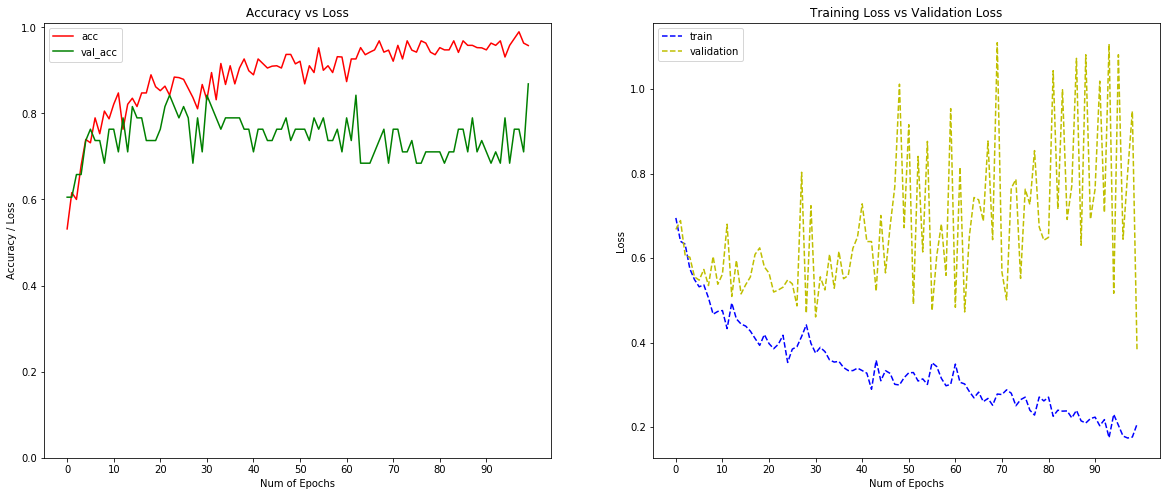

In [12]:
i = 1
resultados = [] ## Array para salvar os resultados de cada execução do algoritmo

for train_index, test_index in skf.split(X_treinamento, y_treinamento):
    print("FOLD: ", i, "/", K, "TRAIN sets:", len(train_index), "TEST  sets:", len(test_index))
    i = i + 1
    
    X_train, X_test = X_treinamento[train_index], X_treinamento[test_index]
    y_train, y_test = y_treinamento[train_index], y_treinamento[test_index]
    
    base_treinamento, base_teste = create_ImageDataGenerators(X_train, y_train, X_test, y_test)
    
    classificador = create_network()
    classificador.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        
    cnn = classificador.fit_generator(base_treinamento, steps_per_epoch = nb_train_samples // batch_size,
                                epochs = epochs, validation_data = base_teste,
                                validation_steps = nb_validation_samples // batch_size, verbose = 0)
    
    # CLassifica os dados que foram separados para o teste final do modelo.
    previsoes = classificador.predict(X_test)
    previsoes = (previsoes > 0.5) # Se a saida for > 0.5 -> classe 1 senão classe 0
    
    from sklearn.metrics import confusion_matrix, accuracy_score
    accuracy = accuracy_score(y_test, previsoes)
    matriz = confusion_matrix(y_test, previsoes)

    print('Accuracy: ', accuracy)
    print('Matriz de confusão:')
    print(matriz)
    
    resultados.append(accuracy)
    plot_graphs(cnn)
    
    
    #precisao = classificador.evaluate(X_test, y_test)
    #resultados.append(precisao[1])

In [13]:
from statistics import mean, stdev
print('Max: ', max(resultados))
print('Min: ', min(resultados))
print('Média: ', mean(resultados))
print('SD: ', stdev(resultados))

Max:  0.95
Min:  0.7105263157894737
Média:  0.8007894736842105
SD:  0.10405390942430752
